### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

### Import and clean Melbourne housing dataset

In [2]:
housing = pd.read_csv('./melb_data.csv')
housing_dropped = housing.drop(["Address", "Distance", "Postcode", "CouncilArea", "Lattitude", "Longtitude", "Regionname", "Propertycount"], axis=1)

columns_to_convert = ['Suburb', 'Type', 'Method', 'SellerG', 'Date']
housing_dropped[columns_to_convert] = housing_dropped[columns_to_convert].astype('category')

for i in columns_to_convert:
    housing_dropped[f'{i}_enc'] = housing_dropped[i].cat.codes

housing_enc = housing_dropped.drop(columns_to_convert, axis=1)

x = housing_enc.drop('Price', axis=1)
y = housing_enc['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.7, random_state=42)

x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_train.median())

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Calculate RMSE and R-squared values for all regression models we have fitted for the Melbourne housing dataset

In [3]:
model_linear = LinearRegression()
model_linear = model_linear.fit(x_train, y_train)
y_pred_linear = model_linear.predict(x_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x_train, y_train)
y_pred_ridge = ridge_model.predict(x_test)

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(x_train, y_train)
y_pred_lasso = lasso_model.predict(x_test)

model_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
model_elastic.fit(x_train, y_train)
y_pred_elastic = model_elastic.predict(x_test)

tree_model = DecisionTreeRegressor(random_state=0)
tree_model.fit(x_train, y_train)
y_pred_tree = tree_model.predict(x_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(x_train, y_train)
y_pred_gb = gb_model.predict(x_test)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(x_train, y_train)
y_pred_svr = svr_model.predict(x_test)

nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_model.fit(x_train, y_train)
y_pred_nn = nn_model.predict(x_test)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

/home/jiajia/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Create a dataframe that contains 3 columns which are 'Model', 'RMSE', and 'R-squared'

In [4]:
y_preds = [y_pred_linear, y_pred_ridge, y_pred_lasso, y_pred_elastic, y_pred_tree, y_pred_rf, y_pred_gb, y_pred_svr, y_pred_nn, y_pred_xgb]

model_names = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor',
               'SVR', 'MLPRegressor', 'XGBRegressor']
RMSE = []
R_squared = []

for i in y_preds:
    mse = mean_squared_error(y_test, i)
    RMSE.append(np.sqrt(mse))
    R_squared.append(r2_score(y_test, i))

scores = {
    'Model': model_names,
    'RMSE': RMSE,
    'R_squared': R_squared
}

df_scores = pd.DataFrame(scores)
df_scores

Model           RMSE  R_squared
0           LinearRegression  507479.268670   0.386809
1                      Ridge  506822.406891   0.388395
2                      Lasso  507478.447437   0.386811
3                 ElasticNet  556948.829634   0.261433
4      DecisionTreeRegressor  585393.942413   0.184065
5      RandomForestRegressor  402330.251595   0.614588
6  GradientBoostingRegressor  403216.780268   0.612888
7                        SVR  673163.387725  -0.078947
8               MLPRegressor  794813.711673  -0.504146
9               XGBRegressor  344761.921521   0.716993

### K-fold cross-validation on Melbourne housing dataset with linear regression

In [5]:
scores = cross_val_score(model_linear, x_train, y_train, cv=5, scoring='r2')

print(f'The R-squared value for each fold is: {scores}')
print(f'The mean R-squared value is: {np.mean(scores)}')

The R-squared value for each fold is: [ 0.40124385  0.39251914  0.39614138 -0.21533207  0.4021774 ]
The mean R-squared value is: 0.2753499412295818


### Import and clean the eICU dataset

In [7]:
cohort = pd.read_csv('./eicu_cohort.csv')

cohort['actualhospitalmortality'] = pd.Categorical(cohort['actualhospitalmortality'])
cohort['gender'] = pd.Categorical(cohort['gender'])

cohort['actualhospitalmortality_enc'] = cohort['actualhospitalmortality'].cat.codes
cohort['gender_enc'] = cohort['gender'].cat.codes

cohort_enc = cohort.drop(['actualhospitalmortality', 'gender'], axis=1)

x = cohort_enc.drop('actualhospitalmortality_enc', axis=1)
y = cohort_enc['actualhospitalmortality_enc']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.7, random_state=42)

x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_train.median())

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Stratified k-fold cross-validation on eICU dataset

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression()

scores = cross_val_score(model, x_train, y_train, cv=skf, scoring='accuracy')

print(f'Cross-validation scores (accuracy): {scores}')
print(f'Average score (accuracy): {scores.mean()}')

Cross-validation scores (accuracy): [0.84848485 0.87878788 0.78787879 0.84848485 0.84375   ]
Average score (accuracy): 0.8414772727272727


### Grid search with Ridge regression on Melbourne housing dataset

In [11]:
housing = pd.read_csv('./melb_data.csv')
housing_dropped = housing.drop(["Address", "Distance", "Postcode", "CouncilArea", "Lattitude", "Longtitude", "Regionname", "Propertycount"], axis=1)

columns_to_convert = ['Suburb', 'Type', 'Method', 'SellerG', 'Date']
housing_dropped[columns_to_convert] = housing_dropped[columns_to_convert].astype('category')

for i in columns_to_convert:
    housing_dropped[f'{i}_enc'] = housing_dropped[i].cat.codes

housing_enc = housing_dropped.drop(columns_to_convert, axis=1)

x = housing_enc.drop('Price', axis=1)
y = housing_enc['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.7, random_state=42)

x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_train.median())

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [4]:
np.logspace(-5, 5, 50)

array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-02, 4.71486636e-02, 7.54312006e-02,
       1.20679264e-01, 1.93069773e-01, 3.08884360e-01, 4.94171336e-01,
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])

In [12]:
ridge = Ridge()
param_grid = {'alpha': np.logspace(-4, 4, 50)}

grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='r2')

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score (r-squared): ", best_score)

best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test)

print("Test set score (r-squared): ", test_score)

Best parameters found:  {'alpha': 1.7575106248547894}
Best cross-validation score (r-squared):  0.3994121147382437
Test set score (r-squared):  0.3889546612171909


### Grid search with Gradient Boosting Regressor on Melbourne housing dataset

In [ ]:
gbr = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the individual base learners
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score (r2): ", best_score)

best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test)

print("Test set score (r2): ", test_score)

### `df.describe()` to get a summary of our numerical features

In [3]:
import pandas as pd
housing = pd.read_csv('./melb_data.csv')
housing.describe()

Rooms         Price      Distance      Postcode      Bedroom2  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean       2.937997  1.075684e+06     10.137776   3105.301915      2.914728   
std        0.955748  6.393107e+05      5.868725     90.676964      0.965921   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car       Landsize  BuildingArea    YearBuilt  \
count  13580.000000  13518.000000   13580.000000   7130.000000  8205.000000   
mean       1.534242      1.610075     558.416127    151.967650  1964.684217   
std        0.691712      0.962634    3990.669241    541.014538    37.273762   
min        0.000000      0.000000       0.000000      0.000000  1196.000000   
25%        1.000000      1.000000     177.000000     93.000000  1940.000000   
50%        1.000000      2.000000     440.000000    126.000000  1970.000000   
75%        2.000000      2.000000     651.000000    174.000000  1999.000000   
max        8.000000     10.000000  433014.000000  44515.000000  2018.000000   

          Lattitude    Longtitude  Propertycount  
count  13580.000000  13580.000000   13580.000000  
mean     -37.809203    144.995216    7454.417378  
std        0.079260      0.103916    4378.581772  
min      -38.182550    144.431810     249.000000  
25%      -37.856822    144.929600    4380.000000  
50%      -37.802355    145.000100    6555.000000  
75%      -37.756400    145.058305   10331.000000  
max      -37.408530    145.526350   21650.000000

### Check data types and missing values

In [4]:
print(housing.dtypes)
print(housing.isnull().sum())

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object
Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0

### Data preprocessing - Histograms

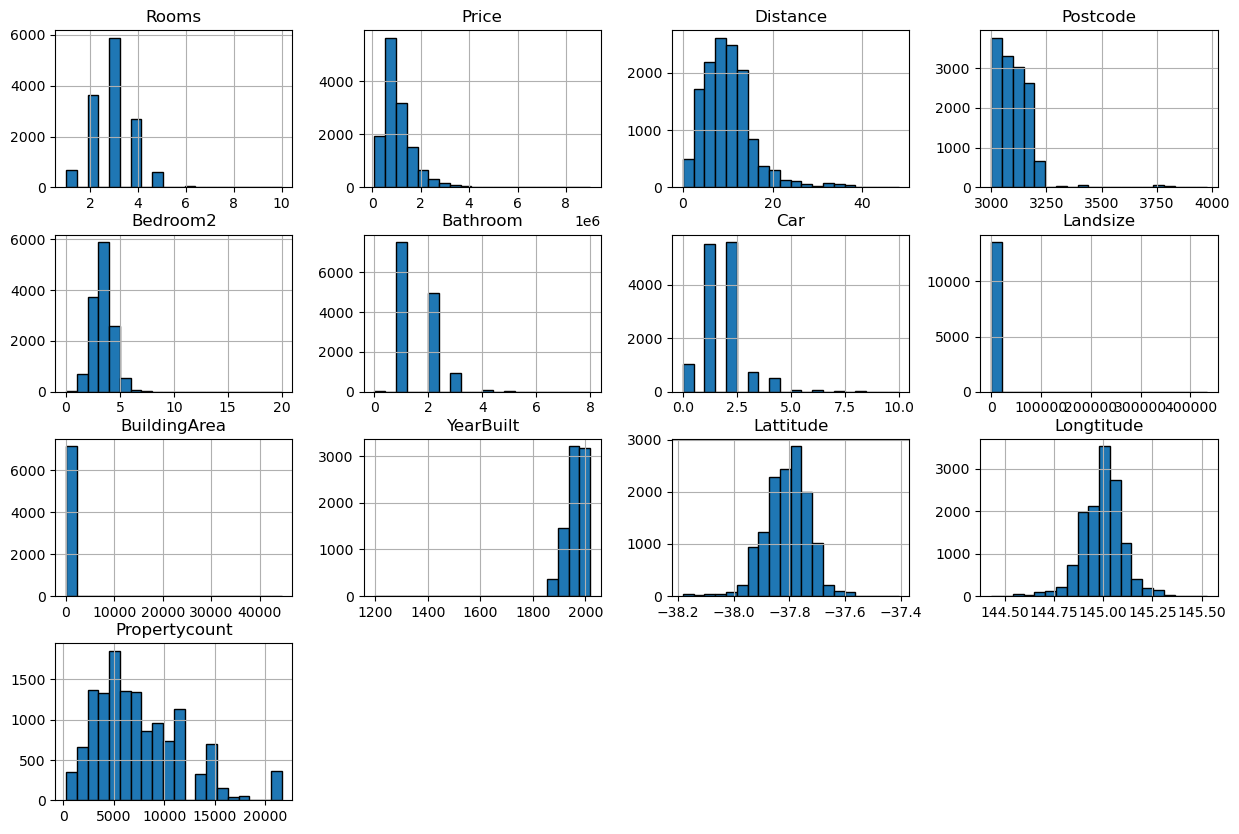

In [16]:
housing.hist(bins=20, edgecolor='black', figsize=(15, 10))
plt.show()

### Data preprocessing - Bar plot

In [17]:
housing.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

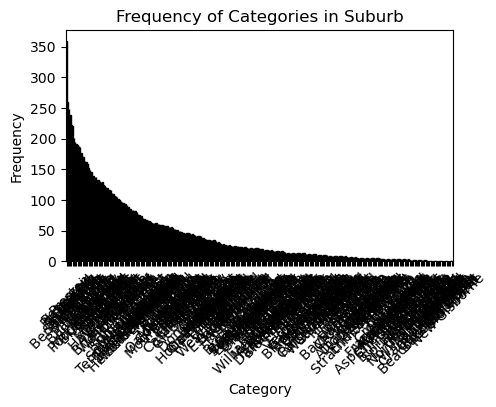

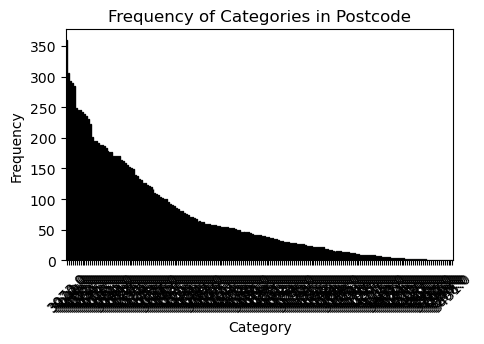

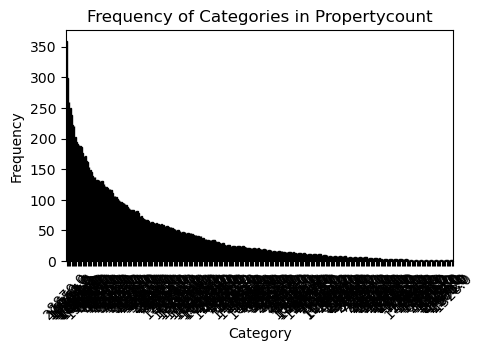

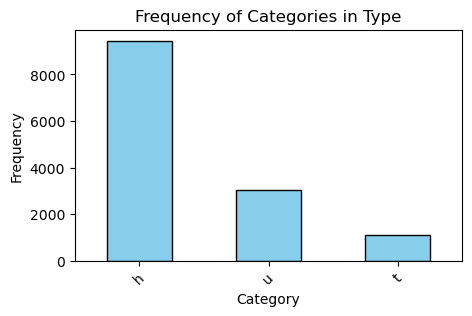

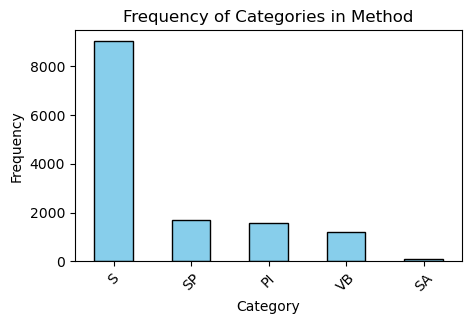

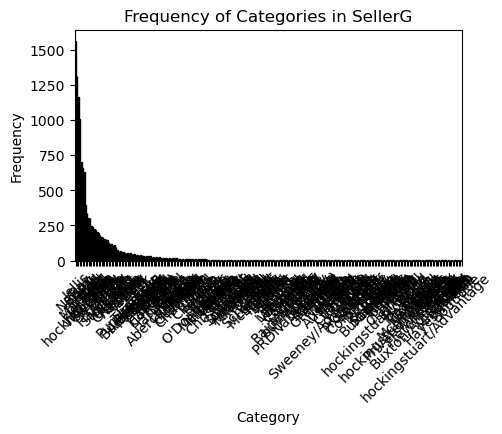

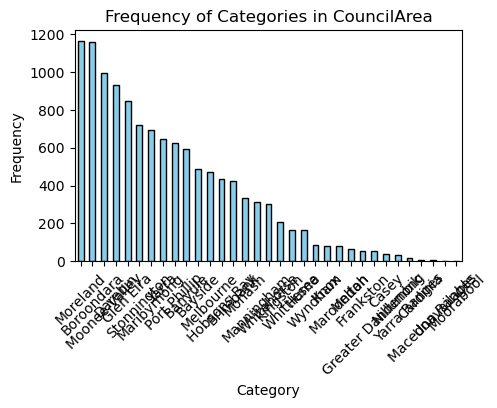

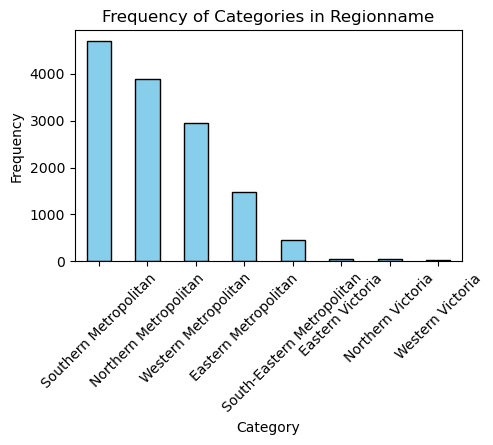

In [19]:
cat_cols = ['Suburb', 'Postcode', 'Propertycount', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

for column in cat_cols:
    plt.figure(figsize=(5, 3))  
    housing[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Frequency of Categories in {column}')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45) 
    plt.show()

### Data preprocessing - Pair plot

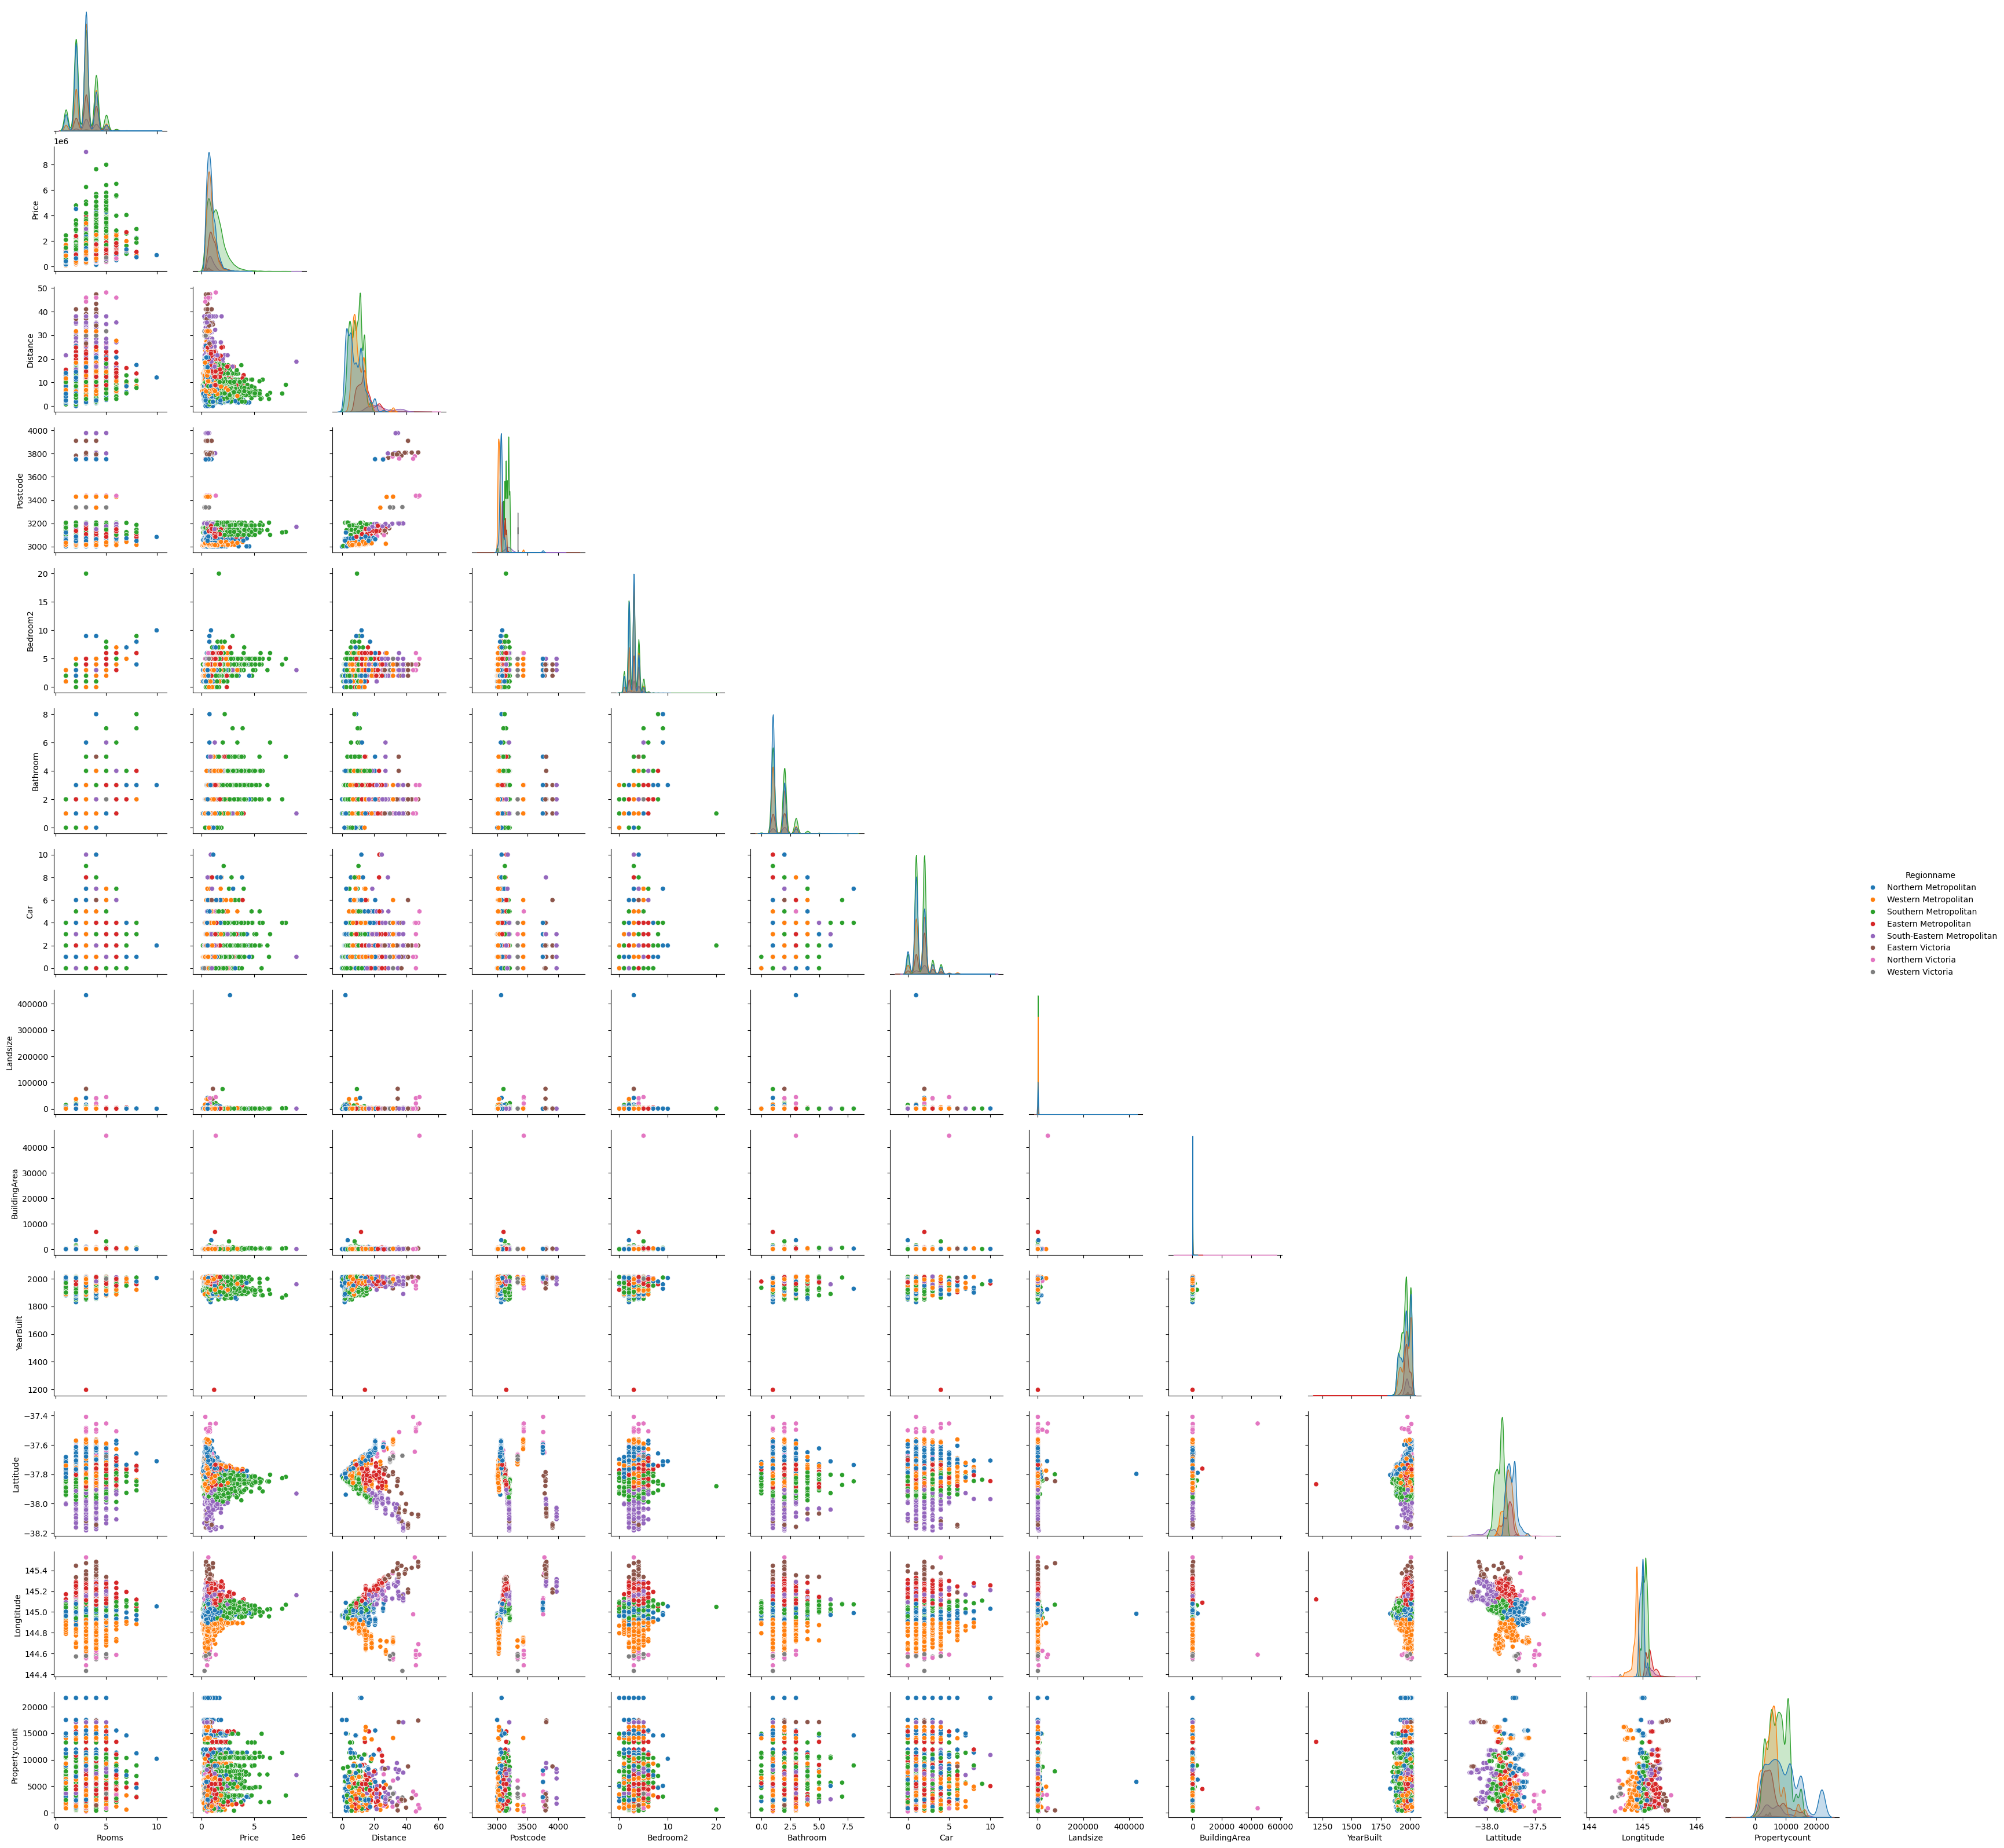

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(housing, corner=True, hue='Regionname')
plt.show()

### Data preprocessing - Correlation analysis

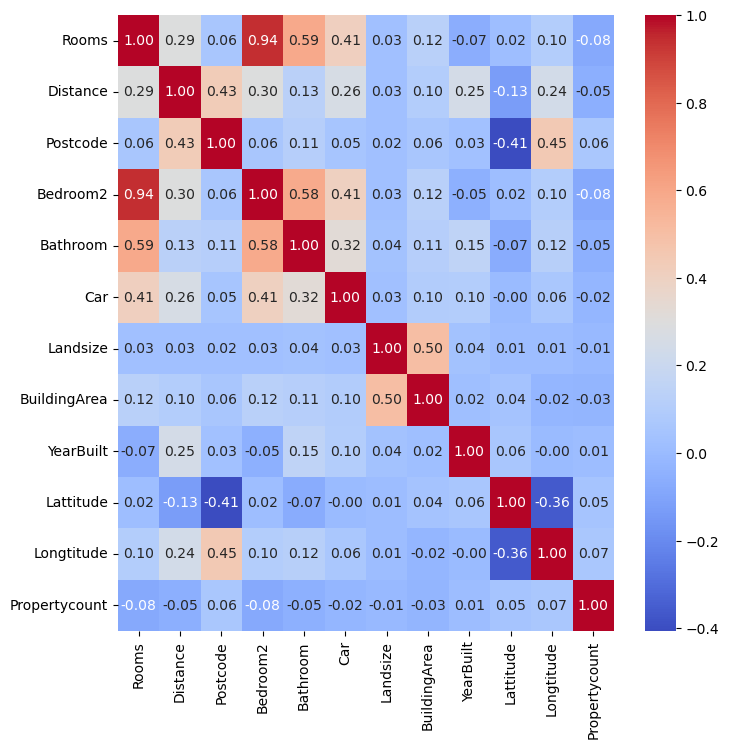

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

df = housing.drop('Price', axis=1)

plt.figure(figsize=(8,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Data preprocessing - Time series data

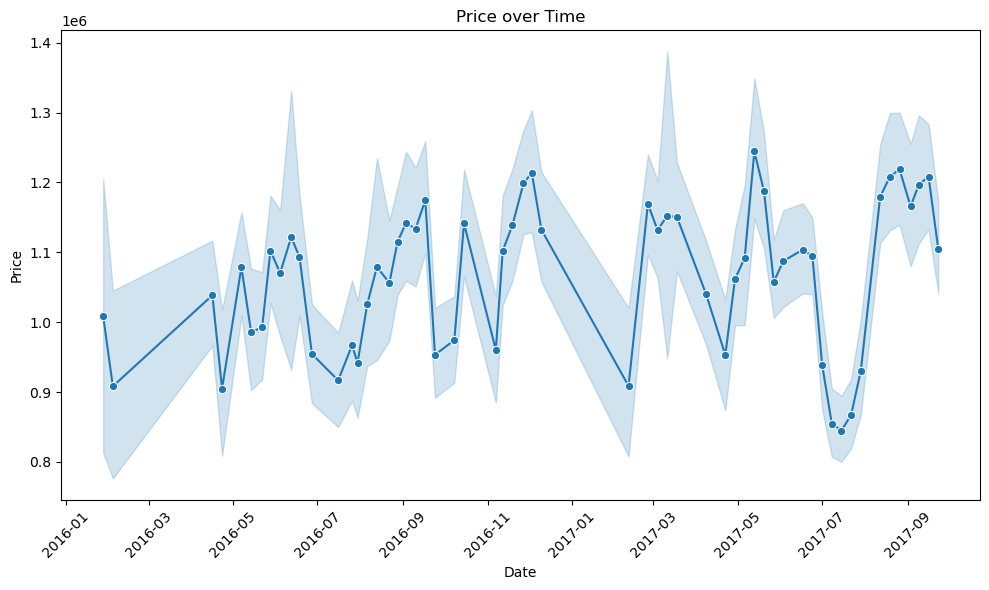

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

housing['Date'] = pd.to_datetime(housing['Date'], format="%d/%m/%Y")

plt.figure(figsize=(10, 6))
sns.lineplot(data=housing, x='Date', y='Price', marker='o')
plt.title('Price over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Get the rows where 'Rooms' > 8

In [12]:
housing_dropped[housing_dropped['Rooms'] > 8]

Suburb  Rooms Type     Price Method SellerG        Date  Bedroom2  \
11304  Bundoora     10    h  900000.0     PI     Ray  15/07/2017      10.0   

       Bathroom  Car  Landsize  BuildingArea  YearBuilt  
11304       3.0  2.0     313.0           NaN     2006.0

### Get the rows where 'Price' > 7000000

In [13]:
housing_dropped[housing_dropped['Price'] > 7000000]

Suburb  Rooms Type      Price Method       SellerG        Date  \
7692   Canterbury      5    h  8000000.0     VB     Sotheby's  13/05/2017   
9575     Hawthorn      4    h  7650000.0      S  Abercromby's  17/06/2017   
12094    Mulgrave      3    h  9000000.0     PI          Hall  29/07/2017   

       Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  
7692        5.0       5.0  4.0    2079.0         464.3     1880.0  
9575        4.0       2.0  4.0    1690.0         284.0     1863.0  
12094       3.0       1.0  1.0     744.0         117.0     1960.0

### Get the rows where 'Bedroom2' is greater than 10

In [14]:
housing_dropped[housing_dropped['Bedroom2'] > 10]

Suburb  Rooms Type      Price Method   SellerG       Date  \
7404  Caulfield East      3    h  1650000.0     PI  Woodards  6/08/2016   

      Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  
7404      20.0       1.0  2.0     875.0           NaN        NaN

### Get the rows where 'Bathroom' is greater than 6

In [15]:
housing_dropped[housing_dropped['Bathroom'] > 6]

Suburb  Rooms Type      Price Method        SellerG        Date  \
379     Ashburton      8    h  2950000.0      S  hockingstuart  10/09/2016   
580        Balwyn      5    h  3900000.0     PI         Jellis  28/08/2016   
4980      Preston      4    h   760000.0     PI          Barry  22/05/2016   
10611  Camberwell      8    h  2200000.0     PI           Ross   8/07/2017   

       Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  
379         9.0       7.0  4.0    1472.0         618.0     2009.0  
580         5.0       7.0  6.0       0.0           NaN        NaN  
4980        9.0       8.0  7.0    1254.0         280.0     1928.0  
10611       8.0       8.0  4.0     650.0           NaN        NaN

### Get the rows where 'Car' is greater than 8

In [16]:
housing_dropped[housing_dropped['Car'] > 8]

Suburb  Rooms Type      Price Method SellerG        Date  \
8963   Surrey Hills      3    h  2100000.0     VB  Jellis   1/07/2017   
9423      Bayswater      4    h   925000.0     SP  Biggin  17/06/2017   
11642     Dandenong      3    h   880000.0      S   Barry  22/07/2017   
13527     Reservoir      4    h  1112000.0      S      RW  26/08/2017   

       Bedroom2  Bathroom   Car  Landsize  BuildingArea  YearBuilt  
8963        3.0       1.0   9.0     841.0         124.0     1960.0  
9423        4.0       1.0  10.0     993.0         128.0     1966.0  
11642       3.0       2.0  10.0     734.0           NaN        NaN  
13527       4.0       2.0  10.0    1002.0         170.0     1985.0

### Get the rows where 'Landsize' > 100000

In [17]:
housing_dropped[housing_dropped['Landsize'] > 100000]

Suburb  Rooms Type      Price Method SellerG        Date  Bedroom2  \
11020  Fitzroy      3    h  2700000.0     VB     Kay  12/08/2017       3.0   

       Bathroom  Car  Landsize  BuildingArea  YearBuilt  
11020       3.0  1.0  433014.0           NaN        NaN

### Get the rows where 'BuildingArea' > 10000

In [18]:
housing_dropped[housing_dropped['BuildingArea'] > 10000]

Suburb  Rooms Type      Price Method SellerG        Date  \
13245  New Gisborne      5    h  1355000.0      S   Raine  23/09/2017   

       Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  
13245       5.0       3.0  5.0   44500.0       44515.0        NaN

### Get the rows where 'YearBuilt' < 1800

In [19]:
housing_dropped[housing_dropped['YearBuilt'] < 1800]

Suburb  Rooms Type      Price Method  SellerG        Date  \
9968  Mount Waverley      3    h  1200000.0     VB  McGrath  24/06/2017   

      Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  
9968       3.0       1.0  4.0     807.0         117.0     1196.0

### Scatter plot for numeric features

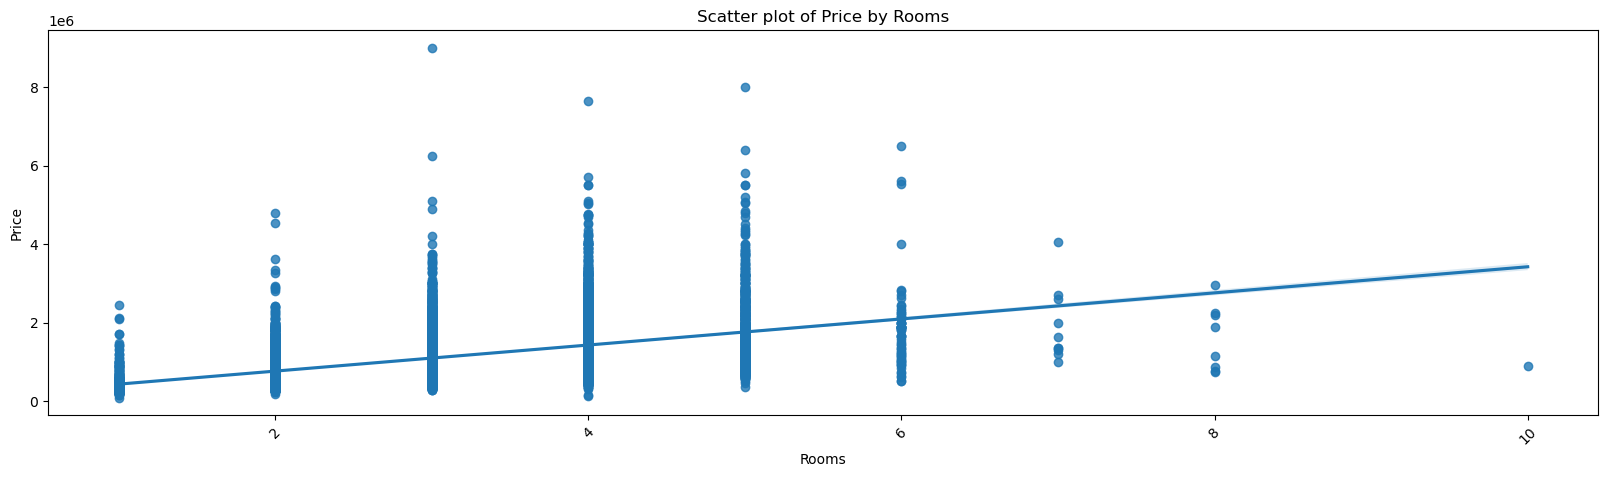

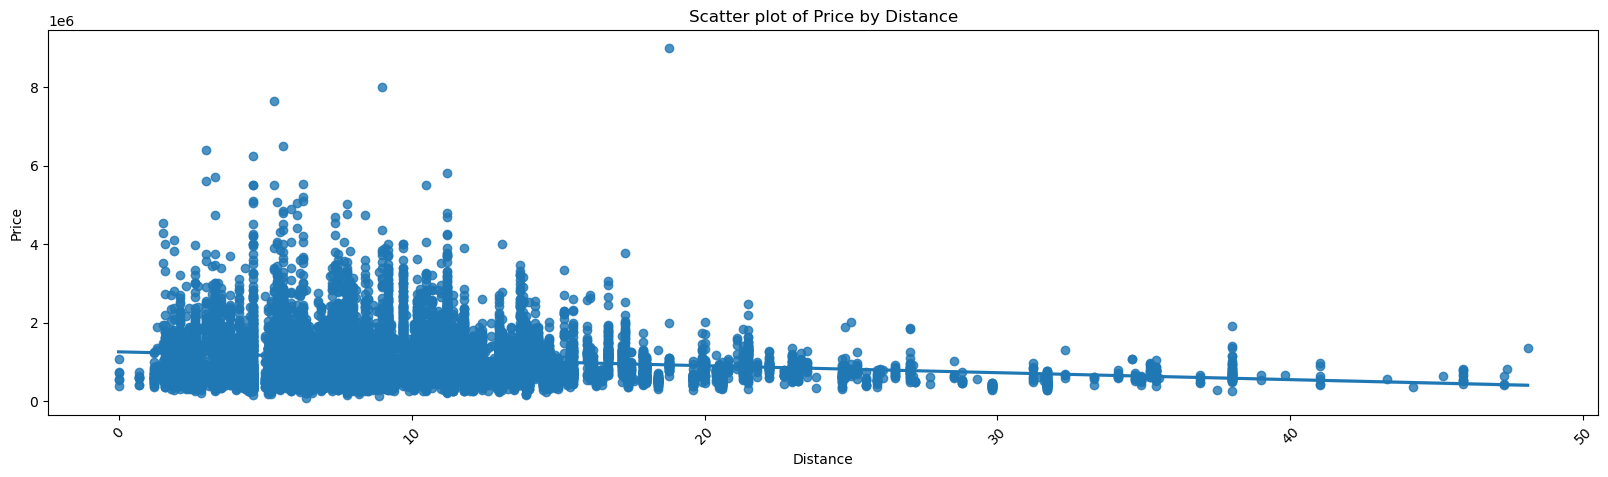

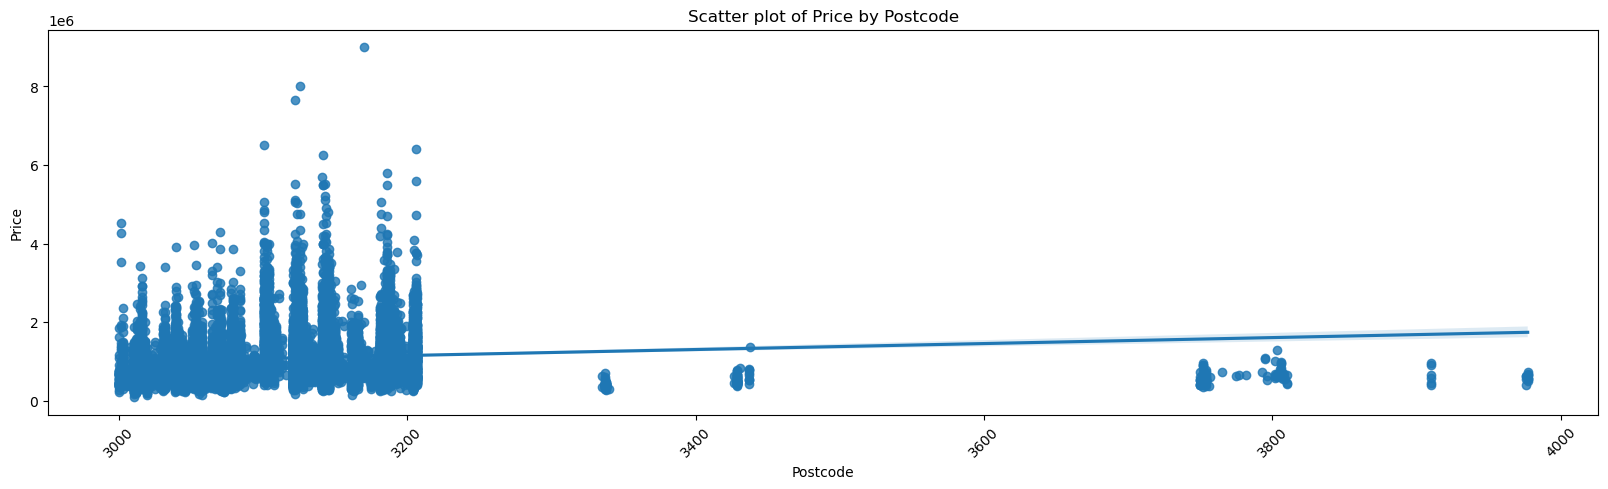

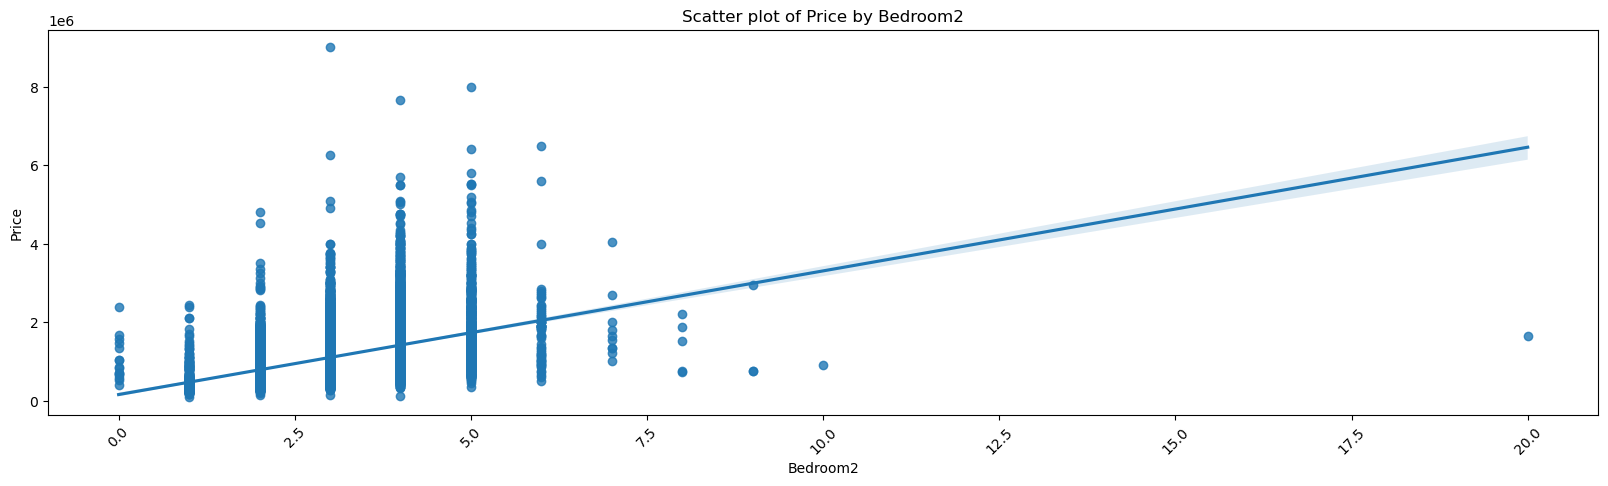

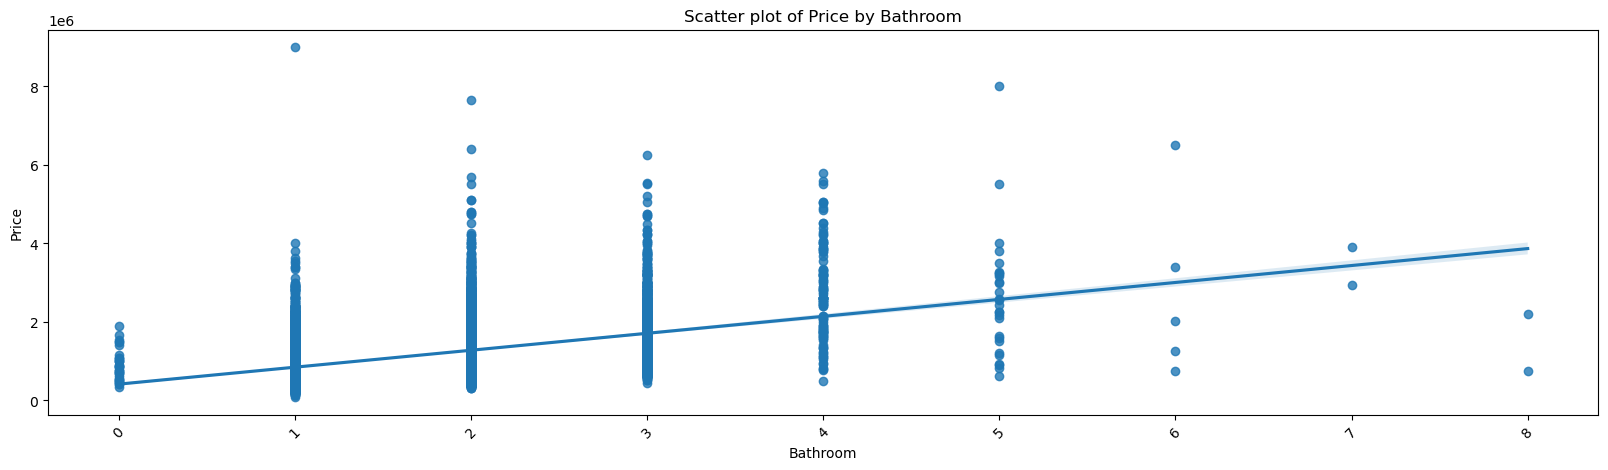

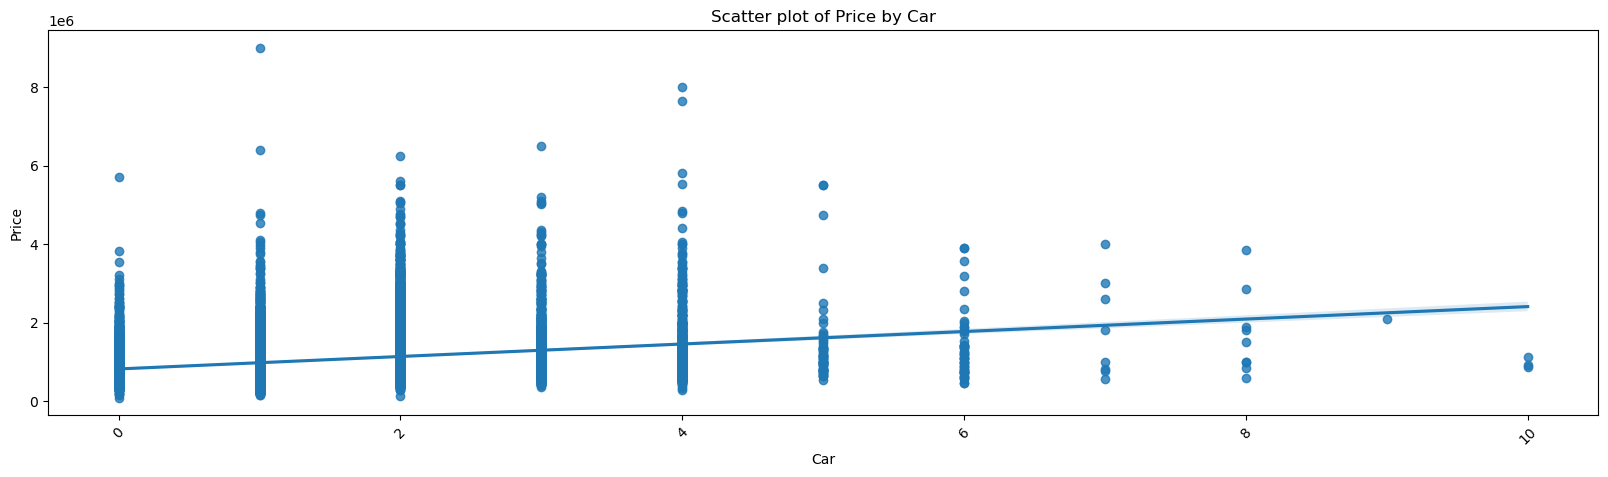

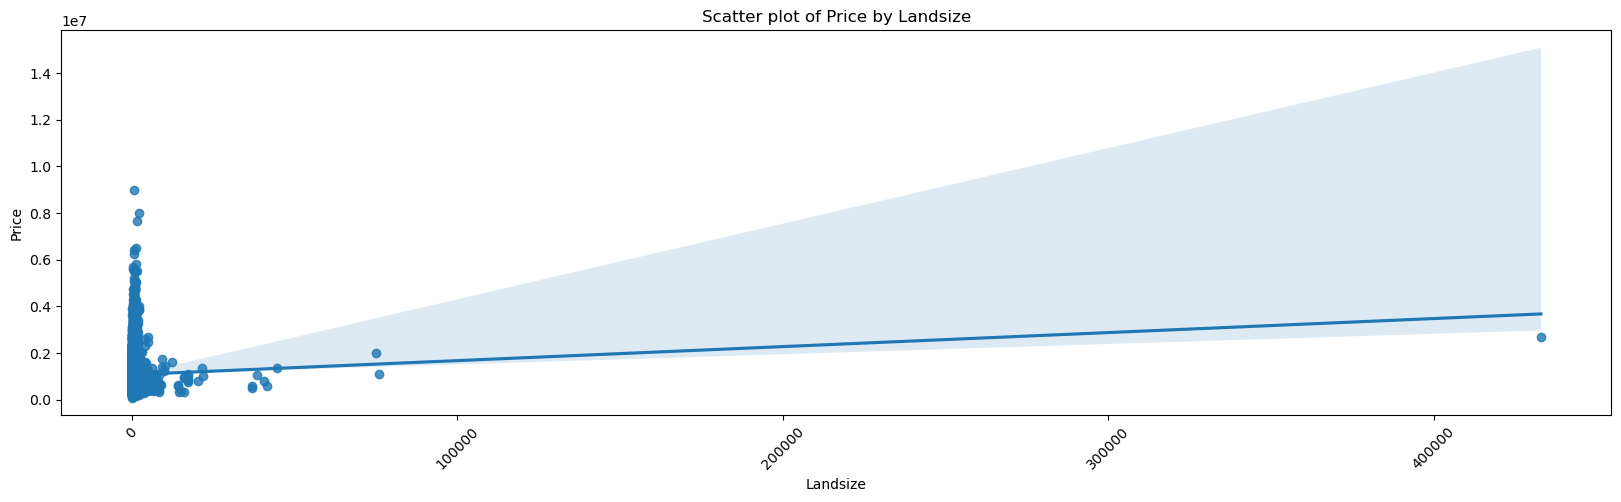

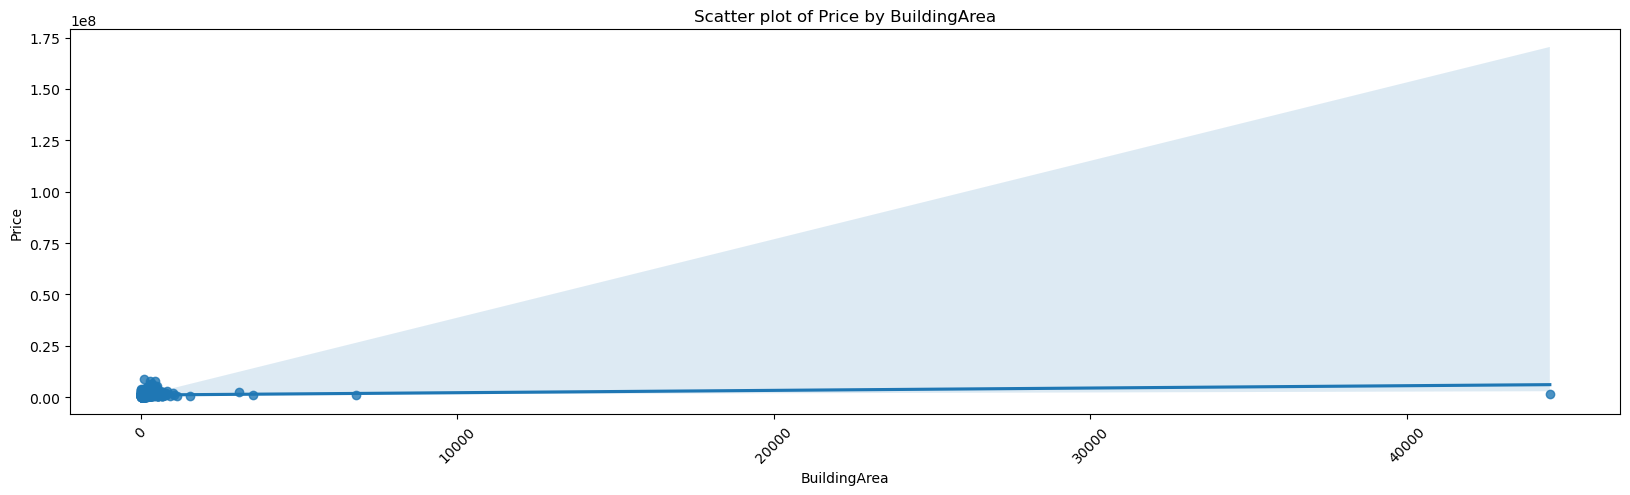

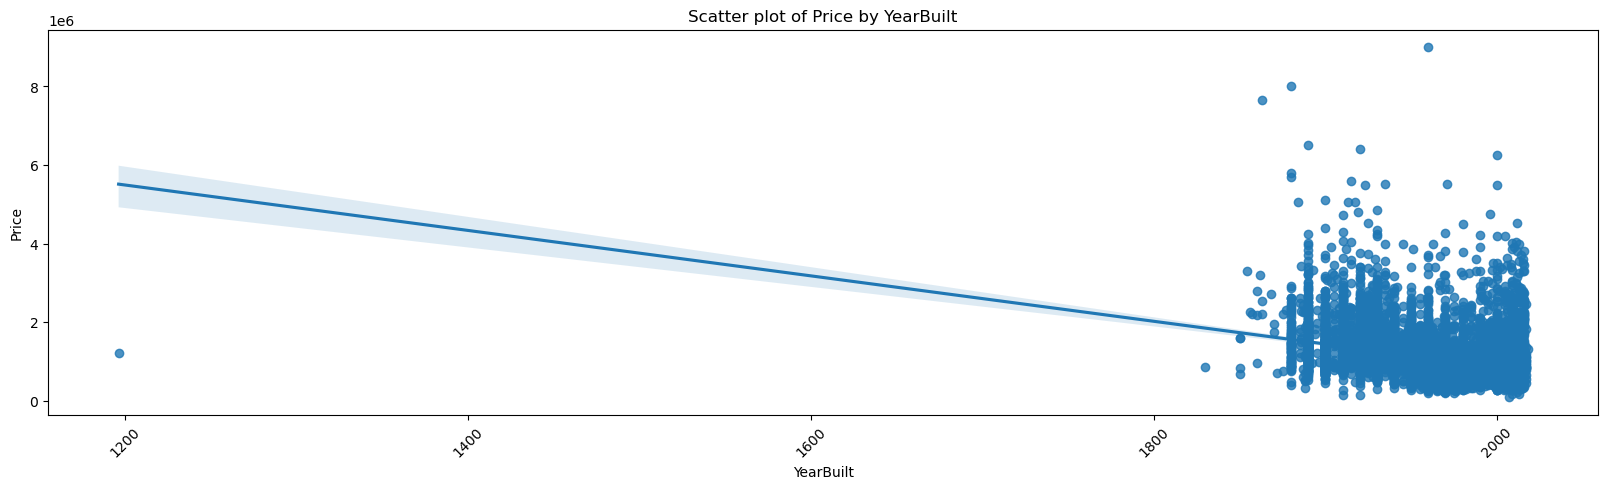

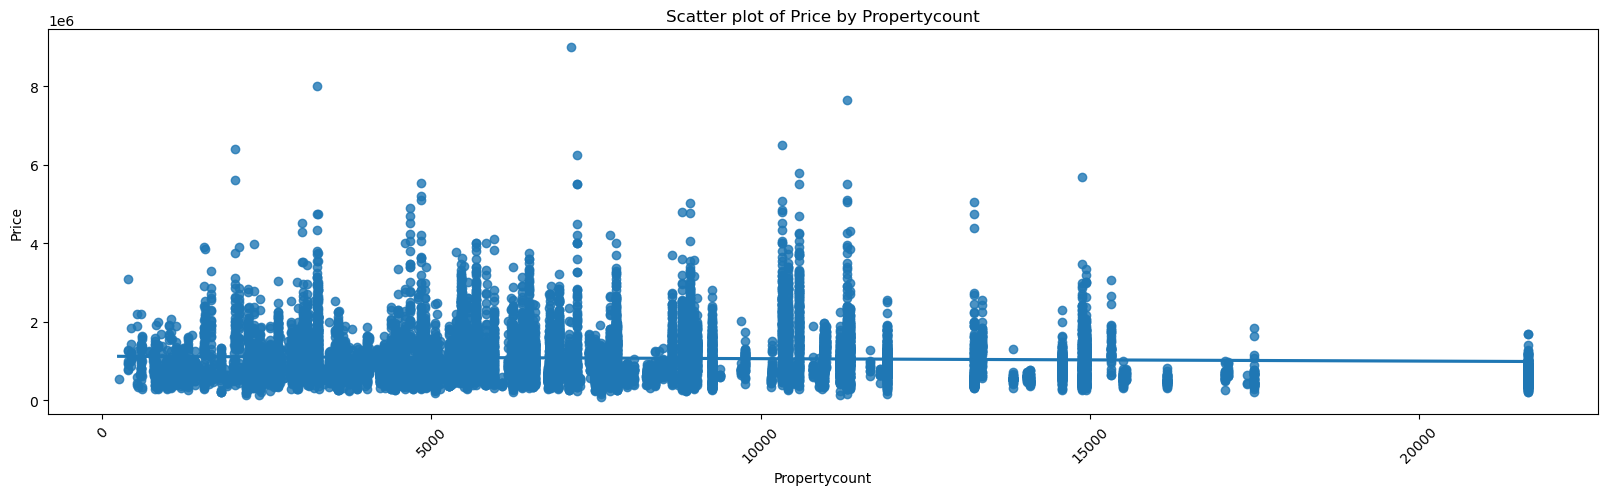

In [64]:
cols = ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']

for column in cols:
    plt.figure(figsize=(20, 5))
    sns.regplot(x=housing[column], y=housing['Price'])
    plt.title(f'Scatter plot of Price by {column}')
    plt.xticks(rotation=45)
    plt.show()

### Box plot visualisation for categorical data

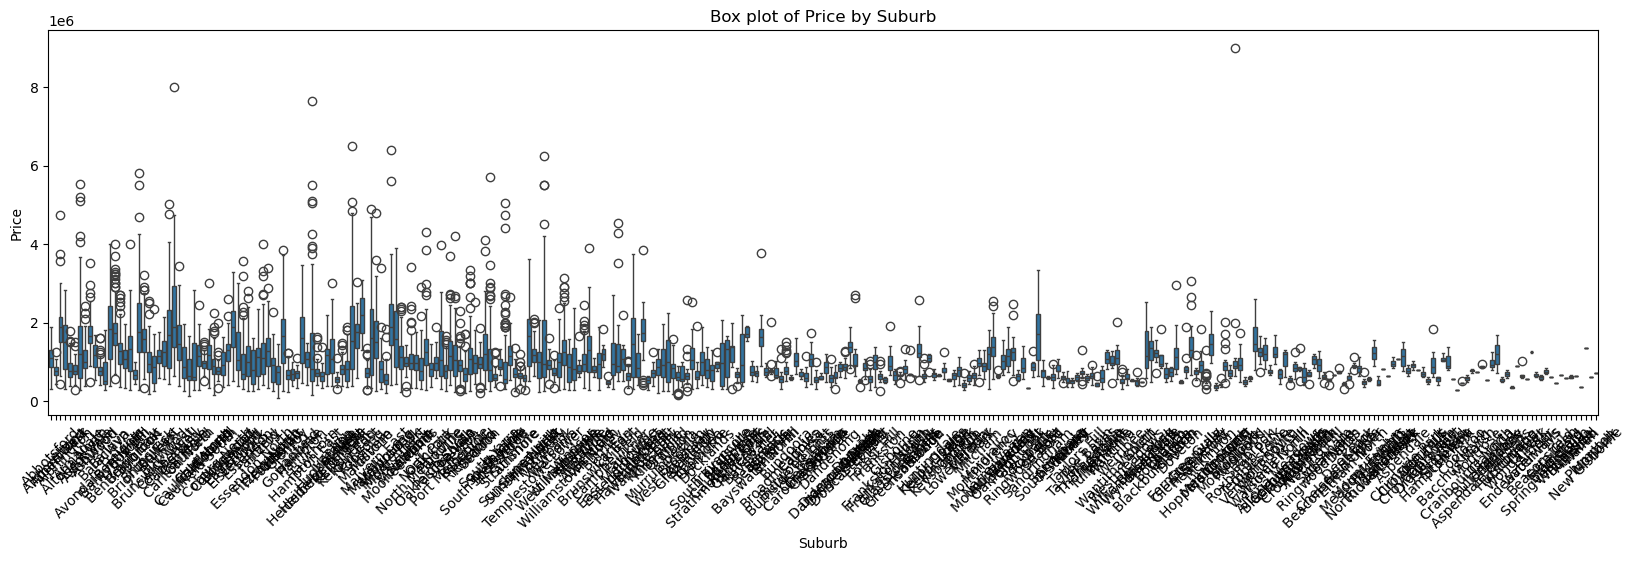

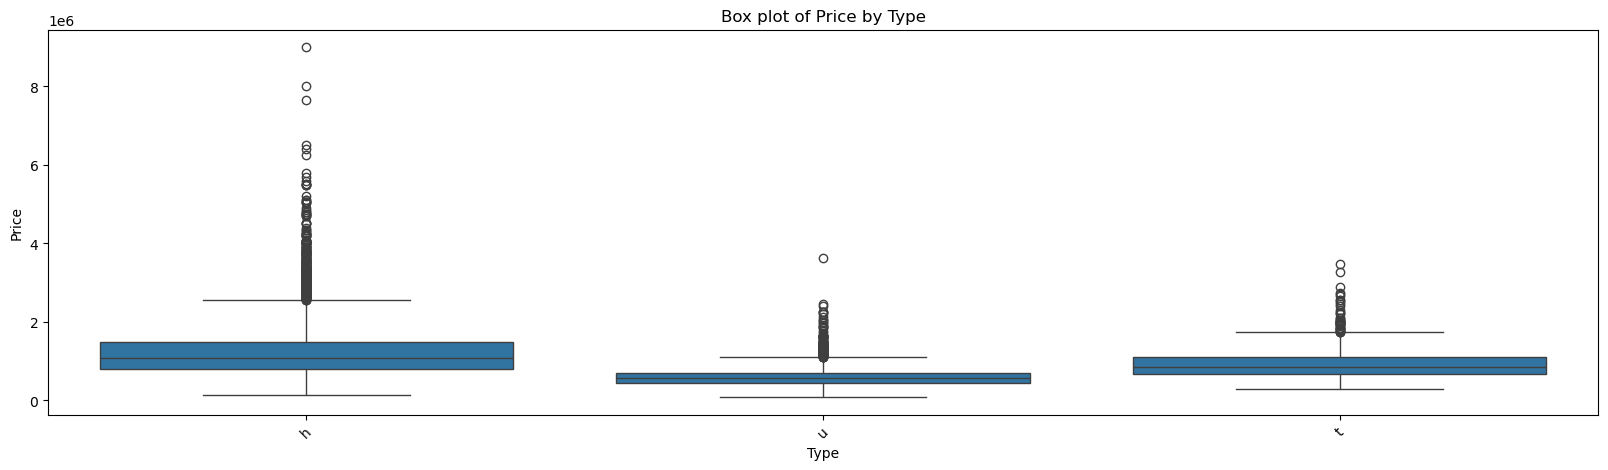

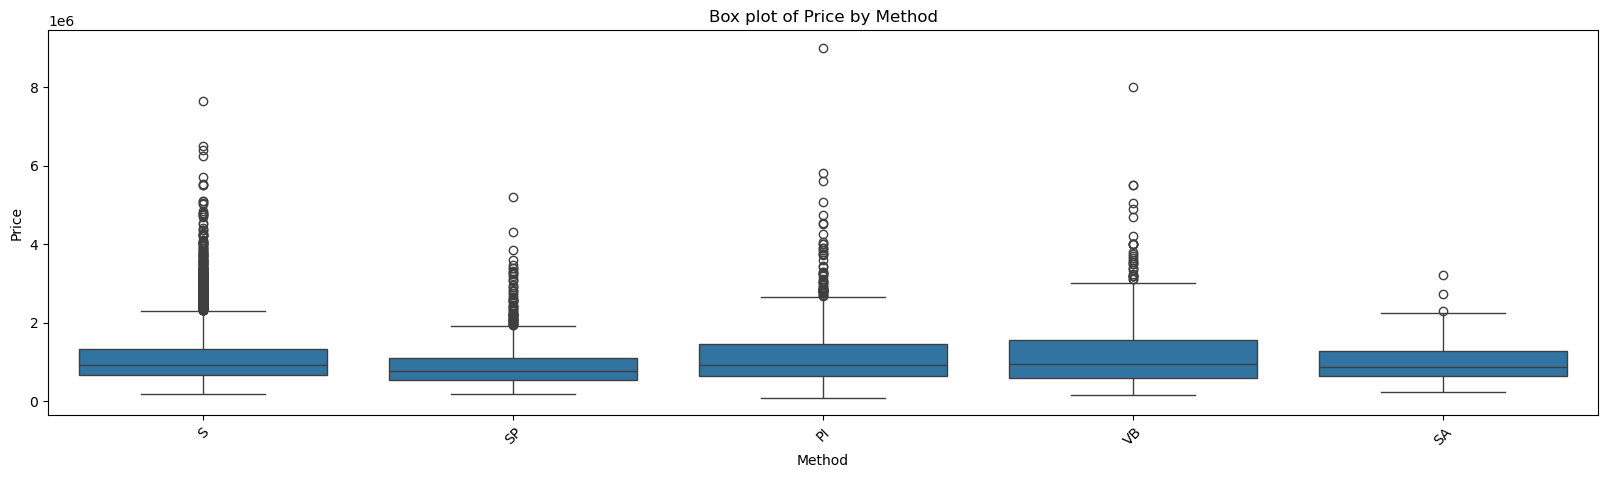

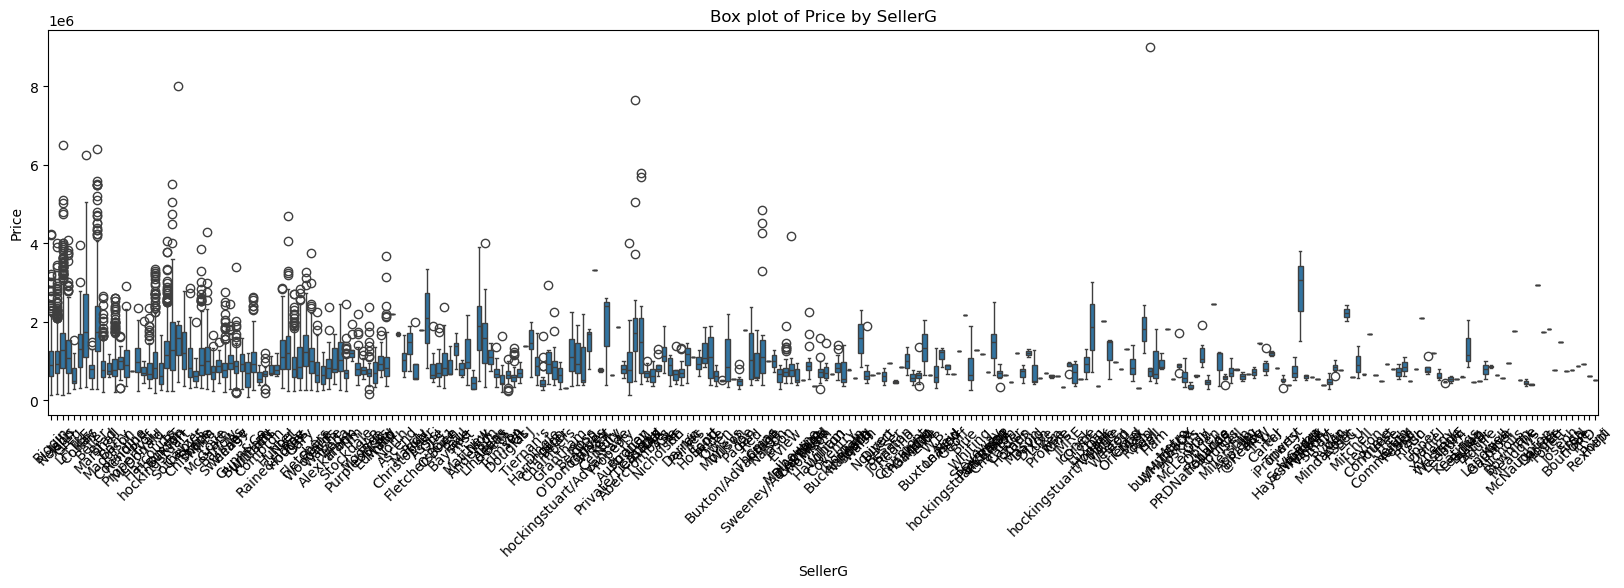

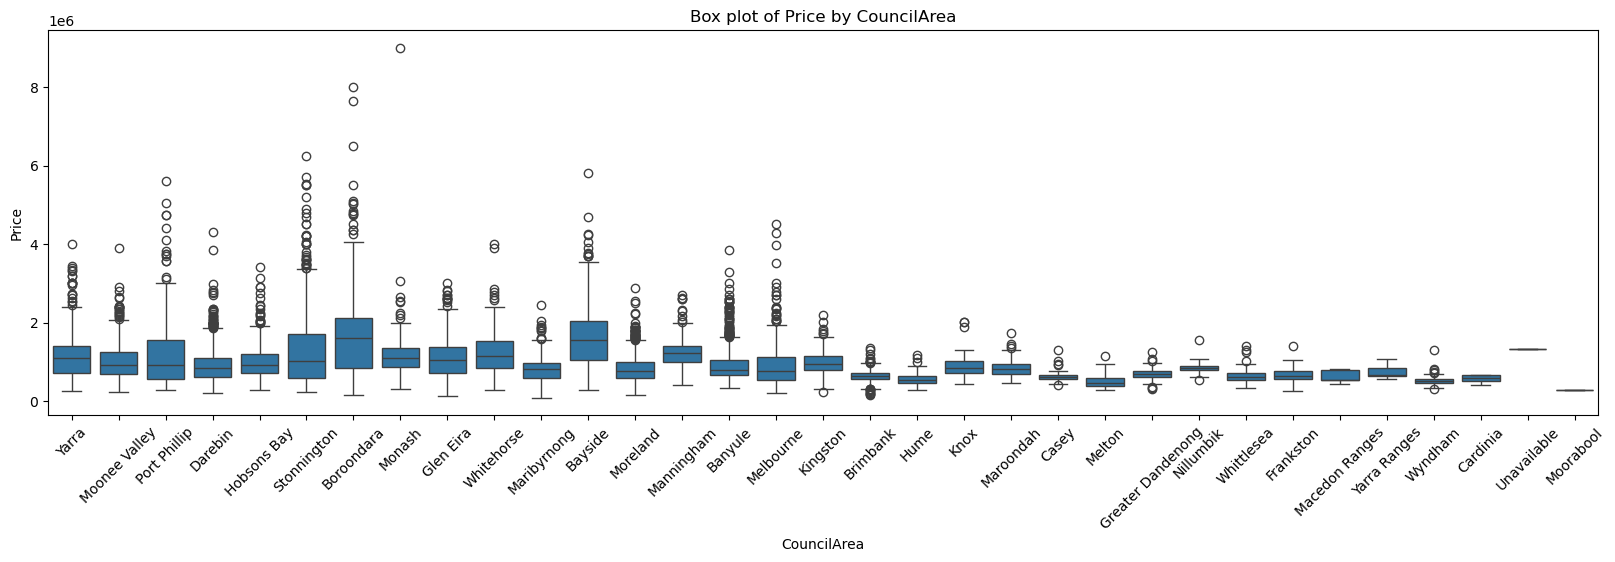

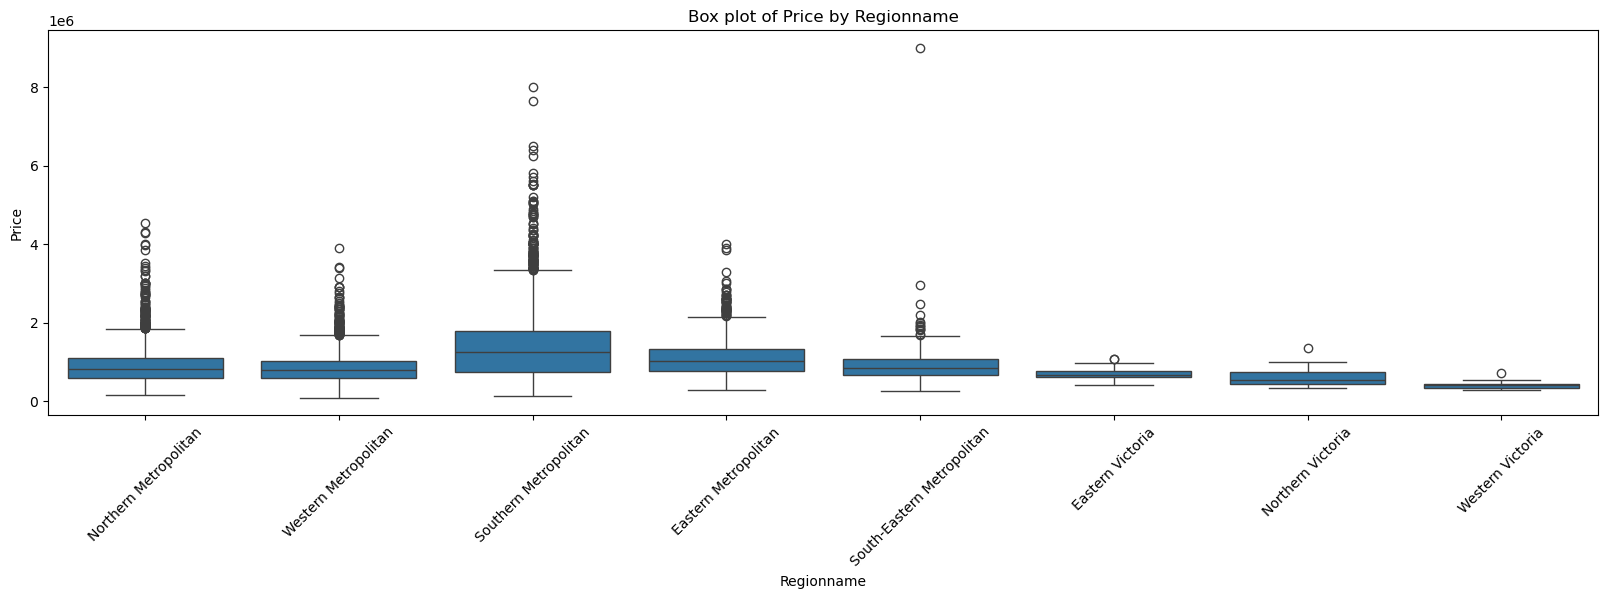

In [44]:
cat_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

for column in cat_cols:
    plt.figure(figsize=(20, 5))
    sns.boxplot(x=housing[column], y=housing['Price'])
    plt.title(f'Box plot of Price by {column}')
    plt.xticks(rotation=45)
    plt.show()